In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data

## Download Data

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip -d ./dataset

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


## Prepare Data

In [2]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C://Users//Dell//Desktop//Project 3 - DPL302m//img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 202599 files belonging to 1 classes.


In [6]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [7]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [8]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


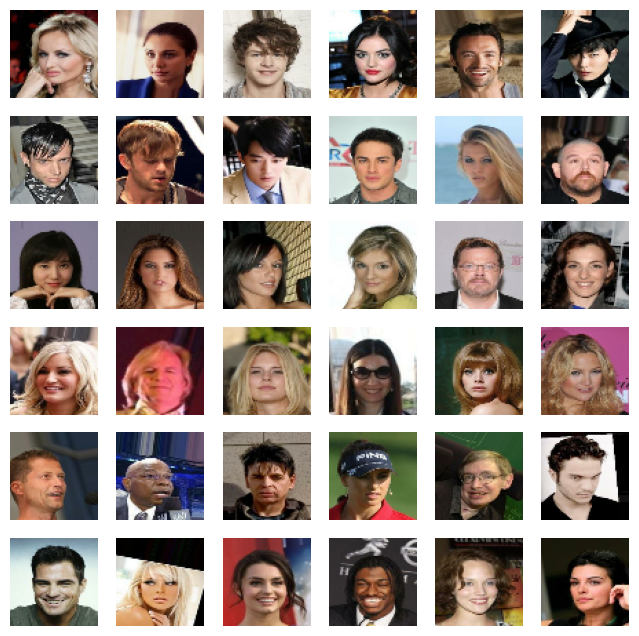

In [12]:
plt.figure(figsize = (8,8))
k=0
n = 36
for i in range(n):
  ax = plt.subplot(6,6, k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k+=1

# MOdeling

In [13]:
generator=tf.keras.Sequential([
  Input(shape=(LATENT_DIM,)),
  Dense(4*4*1024),
  Reshape((4,4,1024)),

  Conv2DTranspose(512,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(3,kernel_size=4,strides=2, activation=tf.keras.activations.tanh, padding='same'),

],name='generator')


# kernel size = 4
# padding = (kernel_size - 1) / 2 = 1.5 = 1

In [14]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         8389120   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 8, 8, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 256)       20

In [15]:
discriminator=tf.keras.Sequential([
  Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3)),

  Conv2D(64,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(1,kernel_size=4,strides=2, padding='same'),

  Flatten(),
  Dense(1,activation='sigmoid')


],name='discriminator')

In [16]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

In [17]:
# class ShowImage(tf.keras.callbacks.Callback):
#     def __init__(self, latent_dim=100):
#         self.latent_dim = latent_dim

#     def on_epoch_end(self, epoch, logs=None):
#         n=6
#         k=0
#         out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
#         plt.figure(figsize=(16,16))
#         for i in range(n):
#           for j in range(n):
#             ax=plt.subplot(n,n,k+1)
#             plt.imshow((out[k]+1)/2,)
#             plt.axis('off')
#             k+=1
#         plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

In [21]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim
        self.fixed_noise = tf.random.normal(shape=(25, self.latent_dim))  # Fixed noise vectors

    def on_epoch_end(self, epoch, logs=None):
        n = 5
        out = self.model.generator(self.fixed_noise)
        plt.figure(figsize=(16, 16))
        for i in range(n):
            for j in range(n):
                ax = plt.subplot(n, n, i * n + j + 1)
                plt.imshow((out[i * n + j] + 1) / 2)
                plt.axis('off')
        plt.savefig("C://Users//Dell//Desktop//Project 3 - DPL302m//generated/gen_images_epoch_{}.png".format(epoch + 1))
        plt.close()  # Close the figure to free memory

In [22]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_images=self.generator(random_noise)

    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

      d_loss=d_loss_real+d_loss_fake

    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [23]:
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [ ]:
!mkdir generated

In [24]:
EPOCHS=2
history=gan.fit(train_dataset,epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/2
1582/1582 [==============================] - 2210s 1s/step - d_loss: 1.2819 - g_loss: 0.8400
Epoch 2/2
1582/1582 [==============================] - 5801s 4s/step - d_loss: 1.2910 - g_loss: 0.7843


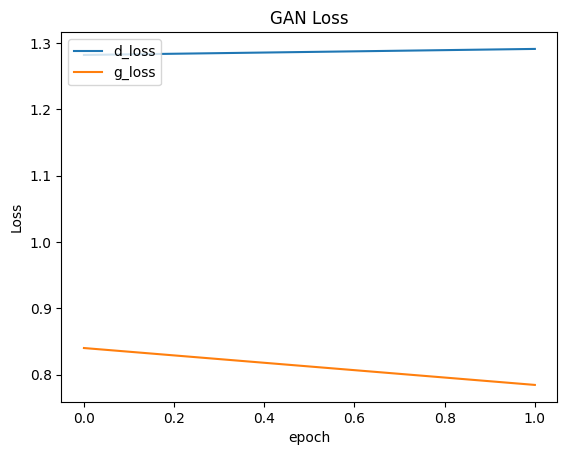

In [25]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()